# Risk Prediction for Home Equity Line of Credit (HELOC)

## 1. introduction

This project aims at developing a predictive model and a decision support system (DSS) that evaluates the risk of Home Equity Line of Credit (HELOC) applications. 

We are assigned with a real-world financial dataset from an anonymized credit bureau.The 23 predictor variables are either quantitative or categorical. The target variable that we are going to predict is a binary variable called RiskPerformance. The value “Bad” means that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. 

#### Import library

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Imputer

#### Load dataset

In [2]:
df = pd.read_csv('heloc_dataset_v1.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
RiskPerformance                       10459 non-null object
ExternalRiskEstimate                  10459 non-null int64
MSinceOldestTradeOpen                 10459 non-null int64
MSinceMostRecentTradeOpen             10459 non-null int64
AverageMInFile                        10459 non-null int64
NumSatisfactoryTrades                 10459 non-null int64
NumTrades60Ever2DerogPubRec           10459 non-null int64
NumTrades90Ever2DerogPubRec           10459 non-null int64
PercentTradesNeverDelq                10459 non-null int64
MSinceMostRecentDelq                  10459 non-null int64
MaxDelq2PublicRecLast12M              10459 non-null int64
MaxDelqEver                           10459 non-null int64
NumTotalTrades                        10459 non-null int64
NumTradesOpeninLast12M                10459 non-null int64
PercentInstallTrades                  10459 non-null int64
MSinc

In [4]:
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


### 2. Data Preprocessing


####  1) Checking and converting the data types



The target to predict the risk is the RiskPerformance variable. The original data consists of two values: good and bad. RiskPeformance is factorized to 0 and 1. 0 represents bad and 1 represents good. 

For variables MaxDelq2PublicRecLast12M and MaxDelqEver, they are categorical variables that represent related records of max delinquency. These variables are converted into categorical variables to facilitate model building.  All other variables remain as numeric type.

In [8]:
categorical1 = pd.get_dummies(data_dict['data_original'][data_dict['features_colnames'][10]])
categorical2 = pd.get_dummies(data_dict['data_original'][data_dict['features_colnames'][11]])
categorical = pd.concat([categorical1,categorical2],axis = 1,ignore_index=True)


#### 2) Dealing with special values
Special values, i.e. -7, -8, -9, are changed according to their meaning. For -9, the original meaning is no bureau record or no investigation. 588 rows are all with -9 and there are only 10 rows with -9 in some of the features. Thus, records that contain -9 are changed as the missing value NaN and dropped. 


In [9]:
df = df.replace(-9,np.nan)
df = df.dropna()

In [10]:
missing_frequency=df.isna().sum()/ len(df)
missing_frequency

RiskPerformance                       0.0
ExternalRiskEstimate                  0.0
MSinceOldestTradeOpen                 0.0
MSinceMostRecentTradeOpen             0.0
AverageMInFile                        0.0
NumSatisfactoryTrades                 0.0
NumTrades60Ever2DerogPubRec           0.0
NumTrades90Ever2DerogPubRec           0.0
PercentTradesNeverDelq                0.0
MSinceMostRecentDelq                  0.0
MaxDelq2PublicRecLast12M              0.0
MaxDelqEver                           0.0
NumTotalTrades                        0.0
NumTradesOpeninLast12M                0.0
PercentInstallTrades                  0.0
MSinceMostRecentInqexcl7days          0.0
NumInqLast6M                          0.0
NumInqLast6Mexcl7days                 0.0
NetFractionRevolvingBurden            0.0
NetFractionInstallBurden              0.0
NumRevolvingTradesWBalance            0.0
NumInstallTradesWBalance              0.0
NumBank2NatlTradesWHighUtilization    0.0
PercentTradesWBalance             

For -7 and -8, the meaning is not the same as missing, but more as invalid values. Thus,-7 and -8 are replaced as the mode of a variable.


In [11]:
df = df.replace(-8, np.nan)
df = df.replace(-7, np.nan)

imputer = Imputer(strategy="most_frequent")
for i in range(1,24):
    df.iloc[:, [i]] = imputer.fit_transform(df.iloc[:, [i]])

####  Visualization 

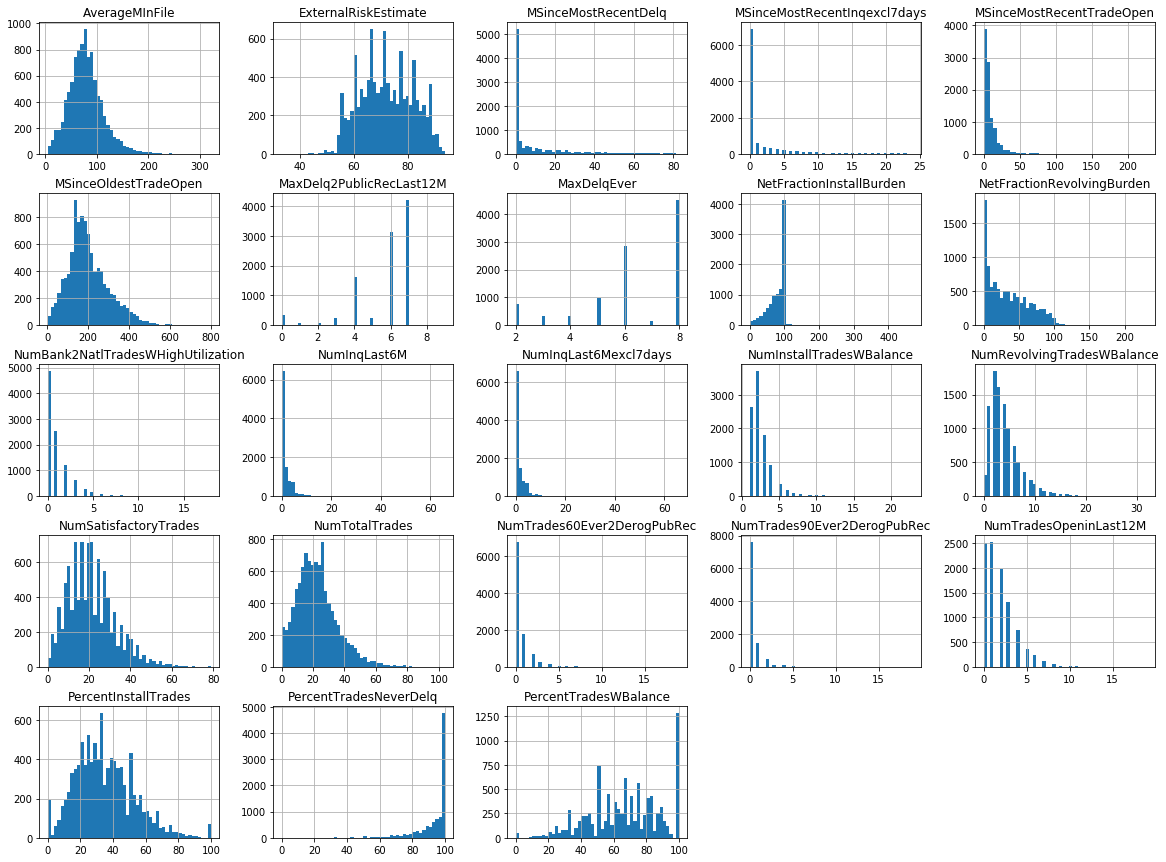

In [14]:
df.hist(bins=50, figsize=(20,15))
pass



A dictionary is built to store the original data, cleaned data, feature names, and factorized target value.  Such a dictionary can keep the data source, facilitate future data manipulation and avoid confusion of all predictors and target value.  

In [15]:
data_dict = {}
data_dict['data_original'] = df
data_dict['features_colnames'] = df.columns
data_dict['y'] = pd.factorize(df['RiskPerformance'])[0]

categorical1 = pd.get_dummies(data_dict['data_original'][data_dict['features_colnames'][10]])
categorical2 = pd.get_dummies(data_dict['data_original'][data_dict['features_colnames'][11]])
categorical = pd.concat([categorical1,categorical2],axis = 1,ignore_index=True)

numeric = pd.concat(([data_dict['data_original'][data_dict['features_colnames'][1:10]],data_dict['data_original'][data_dict['features_colnames'][12:24]]]),axis = 1,ignore_index=True)
data_dict['X'] = pd.concat([categorical,numeric],axis = 1,ignore_index=True)

### 3. Building and Tuning Models

We use Standardscaler  to smooth the magnitude of different features. From the chart above, we could see some continuous features are between [0,800] while others [0,20]. By standardizing features,  their distributions are close to normal distribution. The machine learning models can benefit from the same scale. 

We chose five machine learning models to fit the data: Support Vector Machine (SVM), Logistic Regression (LR), K-Nearest Neighbors (KNN), Random Forest (RF), and Boosting.  


In [16]:

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# 'model_names' contains the names  that we will use for the  classifiers
model_names = ['SVM','LR','KNN','RF','Boosting']

    
# The function `init_classifiers` returns a list of classifiers to be trained on the datas
def init_classifiers():
    return([(SVC(), model_names[0], param_grid_svc), 
            (LogisticRegression(), model_names[1], param_grid_logistic),
            (KNeighborsClassifier(), model_names[2], param_grid_knn),
            (RandomForestClassifier(), model_names[3], param_grid_rf),
            (AdaBoostClassifier(), model_names[4], param_grid_boost)
           ])


def evaluate_model(data_dict, model, model_name, params):
    #split data
    X = data_dict['X']
    y = data_dict['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    data_dict['X_train'] = X_train
    data_dict['X_test'] = X_test
    data_dict['y_train'] = y_train
    data_dict['y_test'] = y_test
    #scale data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    grid_search = GridSearchCV(model, params, cv=3) 
    grid_search.fit(X_train,y_train)
    
    
    model_selection = grid_search.best_estimator_ 
    predictions = model_selection.predict(X_test)

    accuracy = (y_test==predictions).mean() 
    model_dic = {} 
    model_dic['Classifier'] = model_name 
    model_dic['Best Parameter'] = grid_search.best_estimator_.get_params()
    model_dic['Test Score'] = accuracy 
    model_dic['CV Score'] = grid_search.best_score_ 
    
    
    
    return model_dic



# the training parameters of each model
param_grid_svc = [{'C':[0.1,1],'kernel':['rbf','linear','poly'],'max_iter':[-1],'random_state':[1]}]
param_grid_logistic = [{'C':[0.01,0.1,1], 'penalty':['l1','l2'],'random_state':[1]}]
param_grid_knn = [{},{'n_neighbors':[1,2,3,4]}]
param_grid_rf = [{'random_state':[1]},{'n_estimators':[50,100,150,200],'max_features':[0.2, 0.3, 0.5, 0.8], 'bootstrap':[True],'random_state':[1]}]
param_grid_boost = [{'random_state':[1]},{'n_estimators':[50,100,150,200],'learning_rate':[0.1,1],'random_state':[1]}]

In [17]:
res_list = []
classifiers = init_classifiers()
for i in range(len(classifiers)):
    res_list.append(evaluate_model(data_dict, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    
df_model_comparison = pd.DataFrame(res_list, columns = ['Classifier','Best Parameter','Test Score','CV Score']).sort_values(by=['Classifier']).reset_index(drop=True)
    
    
df_model_comparison

,Classifier,Best Parameter,Test Score,CV Score
0,Boosting,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.721237,0.731491
1,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.677648,0.690162
2,LR,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.714648,0.735421
3,RF,"{'bootstrap': True, 'class_weight': None, 'cri...",0.721744,0.730984
4,SVM,"{'C': 0.1, 'cache_size': 200, 'class_weight': ...",0.715661,0.735294


According to the model comparison output, we choose Random Forest as the best model, which has the highest test score of 0.721744 and CV score of 0.730984. The CV score is close to the test score, thus the model is robust.  

In [18]:
rf_para = df_model_comparison.iloc[3,1]
rf_para

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.2,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

### 4. Interface preparation

In [19]:
X = data_dict['X']
y = data_dict['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
data_dict['X_train'] = X_train
data_dict['X_test'] = X_test
data_dict['y_train'] = y_train
data_dict['y_test'] = y_test

In [20]:
import pickle
from sklearn.pipeline import Pipeline

In [23]:
pipe_rf = Pipeline([('minmax', MinMaxScaler()), 
                    ('random forest', RandomForestClassifier(bootstrap = True,
                                                             class_weight = None,
                                                             criterion = 'gini',
                                                             max_depth = None,
                                                             max_features = 0.2,
                                                             max_leaf_nodes = None,
                                                             min_impurity_decrease = 0.0,
                                                             min_impurity_split = None,
                                                             min_samples_leaf = 1,
                                                             min_samples_split = 2,
                                                             min_weight_fraction_leaf = 0.0,
                                                             n_estimators = 100,
                                                             n_jobs = None,
                                                             oob_score = False,
                                                             random_state = 1,
                                                             verbose = 0,
                                                             warm_start = False))])

pipe_rf.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('random forest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=0.2, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [24]:
pickle.dump(data_dict['X_train'], open("X_train.sav", "wb"))
pickle.dump(data_dict['X_test'], open("X_test.sav", "wb"))
pickle.dump(y_test, open("y_test.sav", "wb"))
pickle.dump(y_train, open("y_train.sav", "wb"))
pickle.dump(pipe_rf, open("pipe_rf.sav", "wb"))
